## Strava Ridgeline

In [13]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go


pd.set_option('display.max_rows', None)
strava = pd.read_csv("strava.csv")
strava['month'] = pd.DatetimeIndex(strava['timestamp']).month


The very first thing that I did with this dataset was to explore how the data was structured. What did each row mean? How can I differentiate between running and biking?
<br> <br>
I found via the timestamps that there were many entries (rows) per workout, and that the workouts could each be uniquely identified through the 'datafile' column. I found that there were 64 unnique workouts in this dataset.

In [14]:
strava['datafile'].nunique()

64

By grouping by the datafile and month, we can see that all of the individual workouts have an average speed (in m/s) of either <3 or >5. I believe it is safe to assume that all of the workouts with speeds of < 3 are walking/running workouts, as it would be hard to bike that slowly, and that all of the workouts with speeds of >5 are biking workouts. Conveniently, all running/walking workouts are in July and August, and all biking workouts are in September and October

In [15]:
strava.groupby(['datafile','month']).enhanced_speed.agg('mean').reset_index().head()

,datafile,month,enhanced_speed
0,activities/2675855419.fit.gz,7,2.088154
1,activities/2677658978.fit.gz,7,2.618897
2,activities/2677658993.fit.gz,7,2.683778
3,activities/2677659014.fit.gz,7,2.437679
4,activities/2682705331.fit.gz,7,1.966212


In [16]:
strava['date_week'] = pd.to_datetime(strava['timestamp']).dt.week
# extract the week from the timestamp of workouts
strava.head()

,Air Power,Cadence,Form Power,Ground Time,Leg Spring Stiffness,Power,Vertical Oscillation,altitude,cadence,datafile,...,heart_rate,position_lat,position_long,speed,timestamp,unknown_87,unknown_88,unknown_90,month,date_week
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,activities/2675855419.fit.gz,...,68.0,NaN,NaN,0.0,2019-07-08 21:04:03,0.0,300.0,NaN,7,28
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,activities/2675855419.fit.gz,...,68.0,NaN,NaN,0.0,2019-07-08 21:04:04,0.0,300.0,NaN,7,28
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,activities/2675855419.fit.gz,...,71.0,NaN,NaN,1316.0,2019-07-08 21:04:07,0.0,300.0,NaN,7,28
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3747.0,77.0,activities/2675855419.fit.gz,...,77.0,504432050.0,-999063637.0,1866.0,2019-07-08 21:04:14,0.0,100.0,NaN,7,28
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3798.0,77.0,activities/2675855419.fit.gz,...,80.0,504432492.0,-999064534.0,1894.0,2019-07-08 21:04:15,0.0,100.0,NaN,7,28


In [17]:
# In this line, we will create a new dataframe that groups the enhanced speed and the week, and aggregates the count (frequency) of each
# enhanced_speed occurrence.

# Here, we take only walking/running workouts
strava_week = strava[strava['month'] <= 8]

# enhanced speed that was <0.5 was skewing the data, when it was likely resting data
# enhanced speed that was >5 didn't affect the spread of the data, but was creating a long drawn out line on the right hand side
strava_week = strava_week[(strava_week['enhanced_speed'] >=0.7) & (strava_week['enhanced_speed'] <=5 )]

strava_week = strava_week.groupby(['date_week', 'enhanced_speed']).agg({'enhanced_speed': 'count'}).rename(columns={'enhanced_speed': 'count'})
# Resetting the index will be useful later
strava_week = strava_week.reset_index()
strava_week.head()

,date_week,enhanced_speed,count
0,28,0.756,1
1,28,0.821,1
2,28,1.026,1
3,28,1.129,3
4,28,1.138,1


In [18]:
# In the next steps, we begin by initilizing an empty dictionary, and create a list called "weeks" that 
# is a list of the unique weeks that exist in our "strava_week" dataset (list betweeen 28-35)
array_dict = {} 
weeks=list(strava_week['date_week'].unique())
weeks.sort(reverse=False)

 
# Next, we iterate through this list, and for each week, we take the speed and count their frequency. 
# The last line in the for loop is the most important part. For each week, we normalize the data through 
# min max normalization. Without this step, the volume of our data from week to week would 
# be inconsistent, and would be impossible to compare without normalizing.

for week in weeks:
    array_dict[f'x_{week}'] = strava_week[strava_week['date_week']==week]['enhanced_speed'] 
    array_dict[f'y_{week}'] = strava_week[strava_week['date_week']==week]['count']
    array_dict[f'y_{week}'] = (array_dict[f'y_{week}'] - array_dict[f'y_{week}'].min()) / (array_dict[f'y_{week}'].max() - array_dict[f'y_{week}'].min()) 


In [19]:
fig = go.Figure()
# Create a list of ordered months that will match the order in our 'weeks' list variable
week_list= ['Week 1','Week 2', 'Week 3', 'Week 4', 'Week 5', 'Week 6', 'Week 7', 'Week 8']


# After we have initialized our Figure, it is time to add a trace line for each week.
# We achieve this by iterating through the weeks list, and using the values from the cell above to plot values
for index, week in enumerate(weeks):
    fig.add_trace(go.Scatter(
                            x=[0, 5], y=np.full(2, len(weeks)-index),
                            mode='lines', # Create a line of the 'Ridge'
                            line_color='white', # line_color is white to match the grid color
                            ))
                 
    
    fig.add_trace(go.Scatter(
                            x=array_dict[f'x_{week}'],
                            y=array_dict[f'y_{week}'] + (len(weeks)-index) ,
                            fill='tonexty', # creates the density fill of the space under the line
                                            #  there are many different fill arguments. such as tonexty, tozeroy, toself. 
                                            # As the names (concatenated) imply, tontext y is to the next y trace, 
                                            # tozeroy is to the 0 axis, and toself is to the minimum value of itself                            
                            name=f'{week}',))
    
    fig.add_annotation(
                        x=1, # Adding the week labels to each trace, with x location
                        y=len(weeks)-index,  # set the y location of the annotation
                        text=week_list[index], #where both our week_list ordered list and our reset_index() comes in handy
                        showarrow=False, # add_annotation defaults to adding arrows to point to the point of reference, 
                                            # but I don't want that here
                        yshift=10) # The annotation defaults to being directly on the line. I would like it ten units shifted up
    

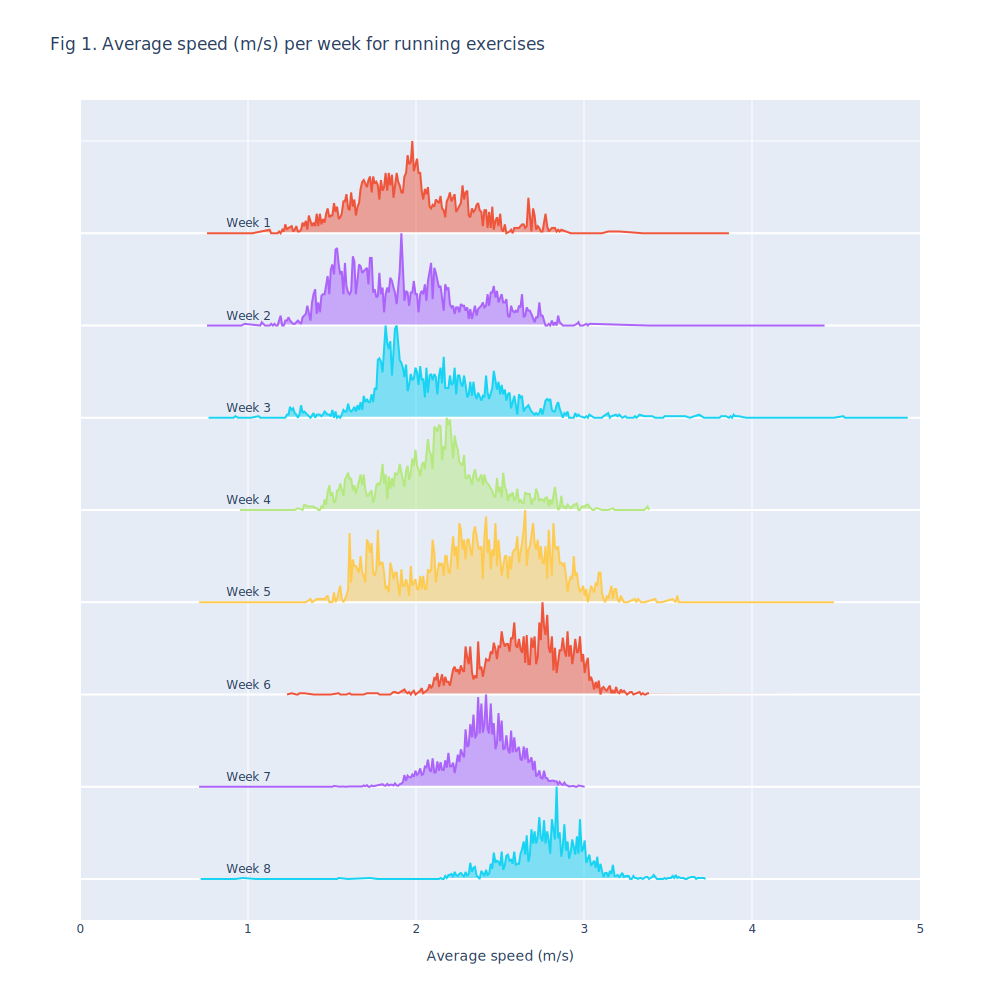

In [22]:
fig.update_layout(
                title='Fig 1. Average speed (m/s) per week for running exercises', # set title label
                showlegend=False, # legend isn't necessary since our annotations are actually more powerful
                xaxis=dict(title='Average speed (m/s)'), # xaxis label
                yaxis=dict(showticklabels=False), 
                autosize=False, # change figure size from the default that is very small
                width=1000,
                height=1000,
                )
fig.show("svg")



The "Couch to 5k" program is designed purposefully as a backloaded exercise program. That is, the program begins slowly with low intensity workouts, and ramps up towards the later weeks. This ridgeline plot perfectly exemplifies this trend week by week. The speed and rigor of the workouts significantly increases over time. The speed in meters per second increase with every weekly iteration (with the exception of week 6 to 7), until Week 8, where the average seems to be a whole meter/second faster on average.